# Simple CNN Clasifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


## Hardaware Verifications

In [3]:
print(torch.version.cuda)

print("CUDA disponible:", torch.cuda.is_available())
print("Dispositivo actual:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Nombre GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

11.8
CUDA disponible: True
Dispositivo actual: 0
Nombre GPU: NVIDIA GeForce RTX 3050 Laptop GPU


## Model Running

In [4]:
# 📁 Cargar datos
df = pd.read_csv("embeddings_csv/all_embeddings.csv")
X = df[[f'emb_{i}' for i in range(1024)]].values
y = df["label"].values

# 🔤 Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

In [ ]:
# 🧪 Dividir datos
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 🔄 Reestructurar como (N, 1, 32, 32)
X_train = X_train.reshape(-1, 1, 32, 32).astype(np.float32)
X_val = X_val.reshape(-1, 1, 32, 32).astype(np.float32)

# 🧱 Crear Datasets y Dataloaders
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)

In [6]:
# 🧠 Definir red neuronal
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)


In [8]:
# 🚀 Entrenar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 21):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device).long()
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Train Loss = {total_loss / len(train_dl):.4f}")


Epoch 1: Train Loss = 1.1059
Epoch 2: Train Loss = 1.0611
Epoch 3: Train Loss = 0.9854
Epoch 4: Train Loss = 0.9578
Epoch 5: Train Loss = 0.8424
Epoch 6: Train Loss = 0.8415
Epoch 7: Train Loss = 0.6457
Epoch 8: Train Loss = 0.6840
Epoch 9: Train Loss = 0.5099
Epoch 10: Train Loss = 0.3550
Epoch 11: Train Loss = 0.5677
Epoch 12: Train Loss = 0.2488
Epoch 13: Train Loss = 0.2137
Epoch 14: Train Loss = 0.2408
Epoch 15: Train Loss = 0.2068
Epoch 16: Train Loss = 0.1201
Epoch 17: Train Loss = 0.0589
Epoch 18: Train Loss = 0.0866
Epoch 19: Train Loss = 0.0871
Epoch 20: Train Loss = 0.0244


In [9]:
# ✅ Evaluar
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

print(classification_report(y_true, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     bobfly1       1.00      1.00      1.00         1
     bubcur1       1.00      1.00      1.00         1
     bubwre1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



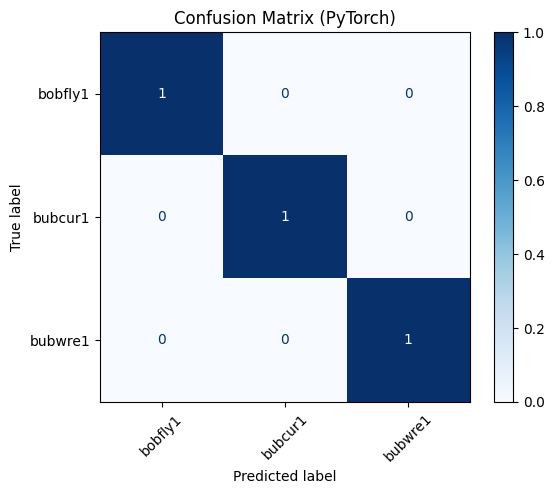

In [10]:
# 📊 Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (PyTorch)")
plt.grid(False)
plt.show()